In [ ]:
pip install torchsummary

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision as tv
from torch import nn
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
import time
from torchsummary import summary

Подготовка данных

In [3]:
# Число бачей
bs = 256
# Преобразование
transoforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [23]:
# Загружаем данные
# Указываю параметр split = 'balanced' для баланса

# На этом совсем плохо обучалось

# train_dataset = tv.datasets.EMNIST('.', train = True, transform=transoforms, download=True, split = 'balanced')
# test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split = 'balanced')
# train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=bs)
# test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=bs)

In [30]:
# Второй вариант
# Указываю параметр split = 'byclass' для большего количества данных
train_dataset = tv.datasets.EMNIST('.', train = True, transform=transoforms, download=True, split = 'byclass')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split = 'byclass')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=bs)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=bs)

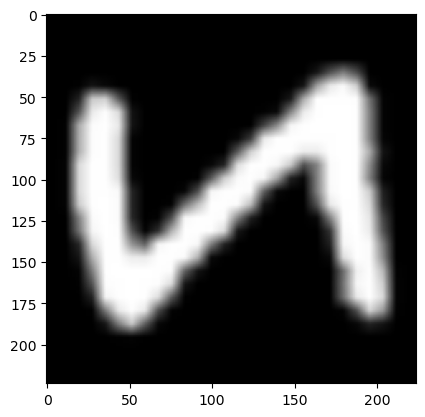

In [31]:
# Пример изображения
plt.imshow(train_dataset[0][0].numpy().reshape(224,224), cmap='gray')

In [32]:
# Число классов - 47 при балансе и 62 всего
len(train_dataset.classes)
# train_dataset.classes

62

In [33]:
# Выбираем девайс, который доступен
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [34]:
# Определение функции обучения

# Тут еще допишем сохранение результатов в словарь, 
#  что бы собрать таблицу для сравнения моделей

def train(net, train_iter, test_iter, trainer, num_epochs):
    d = {}
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
#         данные по эпохам записываем
        d[epoch]: [train_l_sum / n, train_acc_sum / n, test_acc, time.time() - start]
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [35]:
# Точность
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

Архитектура VGG16

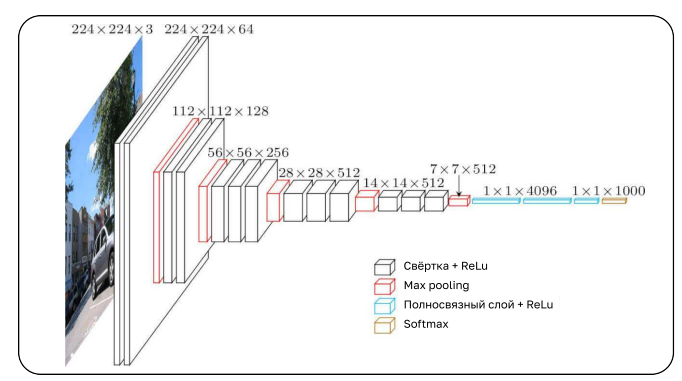

In [ ]:
# Прописываю все слои в модели
# Не очень красиво, зато все наглядно и очевидно 

In [36]:
# Сеть по схеме с уменьшение в четыре раза
model = nn.Sequential(
# две свертки 
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(),
#     nn.Conv2d(16, 16, kernel_size=3, padding=1),
#     nn.ReLU(),
# пулинг и еще две свертки   
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
#     nn.Conv2d(32, 32, kernel_size=3, padding=1),
#     nn.ReLU(),
# пулинг и три свертки
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
#     nn.Conv2d(64, 64, kernel_size=3, padding=1),
#     nn.ReLU(),
# пулинг и три свертки
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=3, padding=1),
#     nn.ReLU(),
# пулинг и три свертки  
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=3, padding=1),
#     nn.ReLU(),   
# последний пулинг
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
# # линейные слои
    nn.Linear(6272, 4096),
    nn.ReLU(), 
    nn.Dropout(0.5),
    nn.Linear(4096, 4096), 
    nn.ReLU(), 
    nn.Dropout(0.5),
    nn.Linear(4096, 62)
)

In [37]:
summary(model.to(device), input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [38]:
# Обучение
# Очень медленно идет
lr, num_epochs  = 0.001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

Step 0. time since epoch: 6.111. Train acc: 0.012. Train Loss: 4.128
Step 10. time since epoch: 57.802. Train acc: 0.042. Train Loss: 3.896
Step 20. time since epoch: 107.786. Train acc: 0.045. Train Loss: 3.806
Step 30. time since epoch: 157.612. Train acc: 0.045. Train Loss: 3.778
Step 40. time since epoch: 207.064. Train acc: 0.045. Train Loss: 3.765
Step 50. time since epoch: 257.033. Train acc: 0.047. Train Loss: 3.757
Step 60. time since epoch: 305.470. Train acc: 0.047. Train Loss: 3.750
Step 70. time since epoch: 355.778. Train acc: 0.048. Train Loss: 3.740
Step 80. time since epoch: 404.795. Train acc: 0.048. Train Loss: 3.734
Step 90. time since epoch: 453.636. Train acc: 0.048. Train Loss: 3.729
Step 100. time since epoch: 503.999. Train acc: 0.048. Train Loss: 3.727
Step 110. time since epoch: 553.102. Train acc: 0.047. Train Loss: 3.726
Step 120. time since epoch: 601.717. Train acc: 0.047. Train Loss: 3.723
Step 130. time since epoch: 650.032. Train acc: 0.047. Train Loss

Step 1120. time since epoch: 5614.087. Train acc: 0.683. Train Loss: 1.094
Step 1130. time since epoch: 5667.272. Train acc: 0.684. Train Loss: 1.089
Step 1140. time since epoch: 5721.203. Train acc: 0.685. Train Loss: 1.084
Step 1150. time since epoch: 5774.716. Train acc: 0.687. Train Loss: 1.078
Step 1160. time since epoch: 5826.532. Train acc: 0.688. Train Loss: 1.073
Step 1170. time since epoch: 5876.419. Train acc: 0.689. Train Loss: 1.068
Step 1180. time since epoch: 5927.700. Train acc: 0.690. Train Loss: 1.062
Step 1190. time since epoch: 5978.988. Train acc: 0.692. Train Loss: 1.058
Step 1200. time since epoch: 6028.543. Train acc: 0.693. Train Loss: 1.053
Step 1210. time since epoch: 6078.606. Train acc: 0.694. Train Loss: 1.048
Step 1220. time since epoch: 6127.228. Train acc: 0.695. Train Loss: 1.043
Step 1230. time since epoch: 6178.254. Train acc: 0.697. Train Loss: 1.038
Step 1240. time since epoch: 6229.971. Train acc: 0.698. Train Loss: 1.033
Step 1250. time since epo

Step 2210. time since epoch: 11430.546. Train acc: 0.763. Train Loss: 0.771
Step 2220. time since epoch: 11480.770. Train acc: 0.763. Train Loss: 0.769
Step 2230. time since epoch: 11531.346. Train acc: 0.763. Train Loss: 0.768
Step 2240. time since epoch: 11583.469. Train acc: 0.764. Train Loss: 0.766
Step 2250. time since epoch: 11633.644. Train acc: 0.764. Train Loss: 0.765
Step 2260. time since epoch: 11685.701. Train acc: 0.764. Train Loss: 0.763
Step 2270. time since epoch: 11736.228. Train acc: 0.765. Train Loss: 0.762
Step 2280. time since epoch: 11788.690. Train acc: 0.765. Train Loss: 0.760
Step 2290. time since epoch: 11838.699. Train acc: 0.766. Train Loss: 0.759
Step 2300. time since epoch: 11889.395. Train acc: 0.766. Train Loss: 0.757
Step 2310. time since epoch: 11940.292. Train acc: 0.766. Train Loss: 0.755
Step 2320. time since epoch: 11992.119. Train acc: 0.767. Train Loss: 0.754
Step 2330. time since epoch: 12044.653. Train acc: 0.767. Train Loss: 0.753
Step 2340. t

Step 570. time since epoch: 2857.746. Train acc: 0.864. Train Loss: 0.367
Step 580. time since epoch: 2921.359. Train acc: 0.864. Train Loss: 0.367
Step 590. time since epoch: 2985.778. Train acc: 0.864. Train Loss: 0.367
Step 600. time since epoch: 3051.164. Train acc: 0.864. Train Loss: 0.366
Step 610. time since epoch: 3114.815. Train acc: 0.864. Train Loss: 0.366
Step 620. time since epoch: 3180.751. Train acc: 0.864. Train Loss: 0.366
Step 630. time since epoch: 3244.808. Train acc: 0.864. Train Loss: 0.366
Step 640. time since epoch: 3309.054. Train acc: 0.864. Train Loss: 0.365
Step 650. time since epoch: 3372.712. Train acc: 0.864. Train Loss: 0.365
Step 660. time since epoch: 3436.495. Train acc: 0.864. Train Loss: 0.365
Step 670. time since epoch: 3500.278. Train acc: 0.864. Train Loss: 0.364
Step 680. time since epoch: 3567.071. Train acc: 0.865. Train Loss: 0.364
Step 690. time since epoch: 3635.150. Train acc: 0.865. Train Loss: 0.364
Step 700. time since epoch: 3703.173. 

Step 1670. time since epoch: 9141.089. Train acc: 0.867. Train Loss: 0.356
Step 1680. time since epoch: 9189.388. Train acc: 0.867. Train Loss: 0.356
Step 1690. time since epoch: 9239.018. Train acc: 0.867. Train Loss: 0.356
Step 1700. time since epoch: 9288.684. Train acc: 0.867. Train Loss: 0.356
Step 1710. time since epoch: 9338.223. Train acc: 0.867. Train Loss: 0.356
Step 1720. time since epoch: 9387.640. Train acc: 0.867. Train Loss: 0.356
Step 1730. time since epoch: 9436.975. Train acc: 0.867. Train Loss: 0.356
Step 1740. time since epoch: 9485.626. Train acc: 0.868. Train Loss: 0.356
Step 1750. time since epoch: 9534.438. Train acc: 0.868. Train Loss: 0.356
Step 1760. time since epoch: 9583.179. Train acc: 0.867. Train Loss: 0.356
Step 1770. time since epoch: 9631.129. Train acc: 0.867. Train Loss: 0.356
Step 1780. time since epoch: 9680.174. Train acc: 0.867. Train Loss: 0.356
Step 1790. time since epoch: 9729.172. Train acc: 0.867. Train Loss: 0.356
Step 1800. time since epo

Step 10. time since epoch: 60.036. Train acc: 0.870. Train Loss: 0.348
Step 20. time since epoch: 117.258. Train acc: 0.871. Train Loss: 0.341
Step 30. time since epoch: 170.679. Train acc: 0.871. Train Loss: 0.339
Step 40. time since epoch: 226.426. Train acc: 0.867. Train Loss: 0.349
Step 50. time since epoch: 279.857. Train acc: 0.868. Train Loss: 0.344
Step 60. time since epoch: 336.299. Train acc: 0.867. Train Loss: 0.348
Step 70. time since epoch: 389.447. Train acc: 0.868. Train Loss: 0.346
Step 80. time since epoch: 443.873. Train acc: 0.870. Train Loss: 0.344
Step 90. time since epoch: 499.471. Train acc: 0.870. Train Loss: 0.344
Step 100. time since epoch: 554.563. Train acc: 0.871. Train Loss: 0.342
Step 110. time since epoch: 608.114. Train acc: 0.871. Train Loss: 0.341
Step 120. time since epoch: 660.701. Train acc: 0.872. Train Loss: 0.339
Step 130. time since epoch: 712.980. Train acc: 0.872. Train Loss: 0.339
Step 140. time since epoch: 765.589. Train acc: 0.872. Train 

Step 1120. time since epoch: 5760.408. Train acc: 0.874. Train Loss: 0.331
Step 1130. time since epoch: 5812.992. Train acc: 0.874. Train Loss: 0.331
Step 1140. time since epoch: 5863.970. Train acc: 0.874. Train Loss: 0.331
Step 1150. time since epoch: 5912.742. Train acc: 0.874. Train Loss: 0.331
Step 1160. time since epoch: 5961.936. Train acc: 0.874. Train Loss: 0.331
Step 1170. time since epoch: 6012.195. Train acc: 0.874. Train Loss: 0.331
Step 1180. time since epoch: 6062.044. Train acc: 0.874. Train Loss: 0.331
Step 1190. time since epoch: 6114.440. Train acc: 0.874. Train Loss: 0.331
Step 1200. time since epoch: 6167.145. Train acc: 0.874. Train Loss: 0.331
Step 1210. time since epoch: 6222.362. Train acc: 0.874. Train Loss: 0.331
Step 1220. time since epoch: 6279.046. Train acc: 0.874. Train Loss: 0.331
Step 1230. time since epoch: 6331.325. Train acc: 0.875. Train Loss: 0.330
Step 1240. time since epoch: 6386.189. Train acc: 0.875. Train Loss: 0.330
Step 1250. time since epo

Step 2210. time since epoch: 11154.355. Train acc: 0.876. Train Loss: 0.325
Step 2220. time since epoch: 11202.122. Train acc: 0.876. Train Loss: 0.325
Step 2230. time since epoch: 11251.583. Train acc: 0.876. Train Loss: 0.325
Step 2240. time since epoch: 11301.512. Train acc: 0.876. Train Loss: 0.325
Step 2250. time since epoch: 11349.395. Train acc: 0.876. Train Loss: 0.325
Step 2260. time since epoch: 11397.382. Train acc: 0.876. Train Loss: 0.325
Step 2270. time since epoch: 11445.355. Train acc: 0.876. Train Loss: 0.325
Step 2280. time since epoch: 11493.527. Train acc: 0.876. Train Loss: 0.325
Step 2290. time since epoch: 11541.420. Train acc: 0.876. Train Loss: 0.325
Step 2300. time since epoch: 11589.474. Train acc: 0.876. Train Loss: 0.325
Step 2310. time since epoch: 11637.743. Train acc: 0.876. Train Loss: 0.325
Step 2320. time since epoch: 11685.653. Train acc: 0.876. Train Loss: 0.325
Step 2330. time since epoch: 11733.624. Train acc: 0.876. Train Loss: 0.325
Step 2340. t

Step 570. time since epoch: 2787.836. Train acc: 0.881. Train Loss: 0.309
Step 580. time since epoch: 2835.915. Train acc: 0.881. Train Loss: 0.309
Step 590. time since epoch: 2884.103. Train acc: 0.881. Train Loss: 0.309
Step 600. time since epoch: 2932.340. Train acc: 0.881. Train Loss: 0.309
Step 610. time since epoch: 2980.201. Train acc: 0.881. Train Loss: 0.308
Step 620. time since epoch: 3028.198. Train acc: 0.882. Train Loss: 0.308
Step 630. time since epoch: 3076.616. Train acc: 0.882. Train Loss: 0.308
Step 640. time since epoch: 3124.657. Train acc: 0.882. Train Loss: 0.308
Step 650. time since epoch: 3172.818. Train acc: 0.882. Train Loss: 0.307
Step 660. time since epoch: 3220.838. Train acc: 0.882. Train Loss: 0.307
Step 670. time since epoch: 3268.662. Train acc: 0.882. Train Loss: 0.307
Step 680. time since epoch: 3317.009. Train acc: 0.882. Train Loss: 0.307
Step 690. time since epoch: 3364.837. Train acc: 0.882. Train Loss: 0.307
Step 700. time since epoch: 3412.818. 

Step 1670. time since epoch: 8132.041. Train acc: 0.883. Train Loss: 0.301
Step 1680. time since epoch: 8181.628. Train acc: 0.883. Train Loss: 0.301
Step 1690. time since epoch: 8231.386. Train acc: 0.883. Train Loss: 0.301
Step 1700. time since epoch: 8281.263. Train acc: 0.883. Train Loss: 0.301
Step 1710. time since epoch: 8330.727. Train acc: 0.883. Train Loss: 0.301
Step 1720. time since epoch: 8379.974. Train acc: 0.883. Train Loss: 0.301
Step 1730. time since epoch: 8429.853. Train acc: 0.883. Train Loss: 0.301
Step 1740. time since epoch: 8479.540. Train acc: 0.883. Train Loss: 0.300
Step 1750. time since epoch: 8529.403. Train acc: 0.883. Train Loss: 0.300
Step 1760. time since epoch: 8578.666. Train acc: 0.883. Train Loss: 0.301
Step 1770. time since epoch: 8628.107. Train acc: 0.883. Train Loss: 0.300
Step 1780. time since epoch: 8677.250. Train acc: 0.883. Train Loss: 0.301
Step 1790. time since epoch: 8726.019. Train acc: 0.883. Train Loss: 0.301
Step 1800. time since epo

Step 20. time since epoch: 104.567. Train acc: 0.883. Train Loss: 0.298
Step 30. time since epoch: 154.391. Train acc: 0.884. Train Loss: 0.291
Step 40. time since epoch: 204.086. Train acc: 0.881. Train Loss: 0.296
Step 50. time since epoch: 253.854. Train acc: 0.883. Train Loss: 0.291
Step 60. time since epoch: 303.707. Train acc: 0.883. Train Loss: 0.294
Step 70. time since epoch: 353.734. Train acc: 0.884. Train Loss: 0.293
Step 80. time since epoch: 403.882. Train acc: 0.886. Train Loss: 0.290
Step 90. time since epoch: 453.644. Train acc: 0.886. Train Loss: 0.289
Step 100. time since epoch: 503.295. Train acc: 0.888. Train Loss: 0.286
Step 110. time since epoch: 552.233. Train acc: 0.888. Train Loss: 0.284
Step 120. time since epoch: 601.030. Train acc: 0.888. Train Loss: 0.283
Step 130. time since epoch: 649.987. Train acc: 0.888. Train Loss: 0.284
Step 140. time since epoch: 698.264. Train acc: 0.888. Train Loss: 0.284
Step 150. time since epoch: 746.986. Train acc: 0.887. Trai

Step 1130. time since epoch: 5559.539. Train acc: 0.890. Train Loss: 0.278
Step 1140. time since epoch: 5609.649. Train acc: 0.890. Train Loss: 0.278
Step 1150. time since epoch: 5658.379. Train acc: 0.890. Train Loss: 0.278
Step 1160. time since epoch: 5707.139. Train acc: 0.890. Train Loss: 0.278
Step 1170. time since epoch: 5755.969. Train acc: 0.890. Train Loss: 0.278
Step 1180. time since epoch: 5805.131. Train acc: 0.890. Train Loss: 0.278
Step 1190. time since epoch: 5854.445. Train acc: 0.890. Train Loss: 0.278
Step 1200. time since epoch: 5903.446. Train acc: 0.890. Train Loss: 0.278
Step 1210. time since epoch: 5951.906. Train acc: 0.890. Train Loss: 0.278
Step 1220. time since epoch: 6000.441. Train acc: 0.890. Train Loss: 0.278
Step 1230. time since epoch: 6049.015. Train acc: 0.890. Train Loss: 0.278
Step 1240. time since epoch: 6097.540. Train acc: 0.891. Train Loss: 0.278
Step 1250. time since epoch: 6145.491. Train acc: 0.891. Train Loss: 0.278
Step 1260. time since epo

Step 2220. time since epoch: 10924.479. Train acc: 0.891. Train Loss: 0.274
Step 2230. time since epoch: 10973.792. Train acc: 0.891. Train Loss: 0.274
Step 2240. time since epoch: 11023.253. Train acc: 0.891. Train Loss: 0.274
Step 2250. time since epoch: 11072.546. Train acc: 0.891. Train Loss: 0.274
Step 2260. time since epoch: 11121.742. Train acc: 0.891. Train Loss: 0.274
Step 2270. time since epoch: 11171.357. Train acc: 0.891. Train Loss: 0.274
Step 2280. time since epoch: 11221.108. Train acc: 0.891. Train Loss: 0.274
Step 2290. time since epoch: 11269.528. Train acc: 0.891. Train Loss: 0.274
Step 2300. time since epoch: 11318.671. Train acc: 0.891. Train Loss: 0.274
Step 2310. time since epoch: 11368.212. Train acc: 0.891. Train Loss: 0.274
Step 2320. time since epoch: 11417.600. Train acc: 0.891. Train Loss: 0.274
Step 2330. time since epoch: 11466.885. Train acc: 0.891. Train Loss: 0.274
Step 2340. time since epoch: 11516.564. Train acc: 0.891. Train Loss: 0.274
Step 2350. t

Step 580. time since epoch: 2859.844. Train acc: 0.896. Train Loss: 0.259
Step 590. time since epoch: 2908.292. Train acc: 0.896. Train Loss: 0.259
Step 600. time since epoch: 2956.796. Train acc: 0.896. Train Loss: 0.259
Step 610. time since epoch: 3006.004. Train acc: 0.896. Train Loss: 0.259
Step 620. time since epoch: 3055.141. Train acc: 0.896. Train Loss: 0.259
Step 630. time since epoch: 3103.627. Train acc: 0.896. Train Loss: 0.259
Step 640. time since epoch: 3152.950. Train acc: 0.896. Train Loss: 0.259
Step 650. time since epoch: 3202.526. Train acc: 0.896. Train Loss: 0.258
Step 660. time since epoch: 3251.696. Train acc: 0.896. Train Loss: 0.258
Step 670. time since epoch: 3301.091. Train acc: 0.896. Train Loss: 0.258
Step 680. time since epoch: 3350.344. Train acc: 0.896. Train Loss: 0.258
Step 690. time since epoch: 3399.627. Train acc: 0.896. Train Loss: 0.258
Step 700. time since epoch: 3448.941. Train acc: 0.896. Train Loss: 0.258
Step 710. time since epoch: 3498.196. 

Step 1680. time since epoch: 8245.853. Train acc: 0.897. Train Loss: 0.255
Step 1690. time since epoch: 8295.395. Train acc: 0.897. Train Loss: 0.255
Step 1700. time since epoch: 8344.898. Train acc: 0.898. Train Loss: 0.255
Step 1710. time since epoch: 8394.268. Train acc: 0.897. Train Loss: 0.255
Step 1720. time since epoch: 8443.749. Train acc: 0.898. Train Loss: 0.255
Step 1730. time since epoch: 8493.035. Train acc: 0.898. Train Loss: 0.255
Step 1740. time since epoch: 8542.173. Train acc: 0.898. Train Loss: 0.255
Step 1750. time since epoch: 8591.571. Train acc: 0.898. Train Loss: 0.255
Step 1760. time since epoch: 8640.951. Train acc: 0.898. Train Loss: 0.255
Step 1770. time since epoch: 8690.435. Train acc: 0.898. Train Loss: 0.255
Step 1780. time since epoch: 8740.192. Train acc: 0.897. Train Loss: 0.255
Step 1790. time since epoch: 8789.895. Train acc: 0.897. Train Loss: 0.255
Step 1800. time since epoch: 8839.574. Train acc: 0.897. Train Loss: 0.255
Step 1810. time since epo

Step 30. time since epoch: 183.668. Train acc: 0.902. Train Loss: 0.243
Step 40. time since epoch: 246.449. Train acc: 0.899. Train Loss: 0.249
Step 50. time since epoch: 298.786. Train acc: 0.902. Train Loss: 0.245
Step 60. time since epoch: 350.966. Train acc: 0.902. Train Loss: 0.245
Step 70. time since epoch: 402.519. Train acc: 0.902. Train Loss: 0.244
Step 80. time since epoch: 454.888. Train acc: 0.903. Train Loss: 0.241
Step 90. time since epoch: 505.500. Train acc: 0.903. Train Loss: 0.240
Step 100. time since epoch: 559.958. Train acc: 0.905. Train Loss: 0.236
Step 110. time since epoch: 612.394. Train acc: 0.905. Train Loss: 0.235
Step 120. time since epoch: 675.565. Train acc: 0.905. Train Loss: 0.235
Step 130. time since epoch: 729.211. Train acc: 0.906. Train Loss: 0.235
Step 140. time since epoch: 792.272. Train acc: 0.906. Train Loss: 0.235
Step 150. time since epoch: 855.681. Train acc: 0.905. Train Loss: 0.237
Step 160. time since epoch: 916.882. Train acc: 0.905. Tra

Step 1140. time since epoch: 5845.519. Train acc: 0.905. Train Loss: 0.235
Step 1150. time since epoch: 5894.990. Train acc: 0.905. Train Loss: 0.234
Step 1160. time since epoch: 5943.164. Train acc: 0.905. Train Loss: 0.234
Step 1170. time since epoch: 5992.413. Train acc: 0.905. Train Loss: 0.234
Step 1180. time since epoch: 6040.938. Train acc: 0.905. Train Loss: 0.235
Step 1190. time since epoch: 6089.183. Train acc: 0.905. Train Loss: 0.235
Step 1200. time since epoch: 6136.979. Train acc: 0.905. Train Loss: 0.234
Step 1210. time since epoch: 6184.520. Train acc: 0.905. Train Loss: 0.234
Step 1220. time since epoch: 6232.599. Train acc: 0.905. Train Loss: 0.234
Step 1230. time since epoch: 6280.339. Train acc: 0.905. Train Loss: 0.234
Step 1240. time since epoch: 6328.204. Train acc: 0.905. Train Loss: 0.234
Step 1250. time since epoch: 6376.848. Train acc: 0.905. Train Loss: 0.234
Step 1260. time since epoch: 6424.888. Train acc: 0.905. Train Loss: 0.234
Step 1270. time since epo

Step 2230. time since epoch: 11258.569. Train acc: 0.907. Train Loss: 0.231
Step 2240. time since epoch: 11306.762. Train acc: 0.907. Train Loss: 0.231
Step 2250. time since epoch: 11354.603. Train acc: 0.907. Train Loss: 0.232
Step 2260. time since epoch: 11402.111. Train acc: 0.906. Train Loss: 0.232
Step 2270. time since epoch: 11453.023. Train acc: 0.906. Train Loss: 0.232
Step 2280. time since epoch: 11505.660. Train acc: 0.906. Train Loss: 0.232
Step 2290. time since epoch: 11557.451. Train acc: 0.906. Train Loss: 0.232
Step 2300. time since epoch: 11668.398. Train acc: 0.906. Train Loss: 0.232
Step 2310. time since epoch: 11720.964. Train acc: 0.906. Train Loss: 0.232
Step 2320. time since epoch: 11772.825. Train acc: 0.906. Train Loss: 0.232
Step 2330. time since epoch: 11827.746. Train acc: 0.906. Train Loss: 0.232
Step 2340. time since epoch: 11882.751. Train acc: 0.906. Train Loss: 0.232
Step 2350. time since epoch: 11934.013. Train acc: 0.906. Train Loss: 0.232
Step 2360. t

Step 590. time since epoch: 3116.135. Train acc: 0.913. Train Loss: 0.216
Step 600. time since epoch: 3166.498. Train acc: 0.913. Train Loss: 0.216
Step 610. time since epoch: 3217.156. Train acc: 0.913. Train Loss: 0.216
Step 620. time since epoch: 3267.518. Train acc: 0.913. Train Loss: 0.216
Step 630. time since epoch: 3317.492. Train acc: 0.913. Train Loss: 0.216
Step 640. time since epoch: 3367.683. Train acc: 0.913. Train Loss: 0.216
Step 650. time since epoch: 3417.551. Train acc: 0.913. Train Loss: 0.216
Step 660. time since epoch: 3467.811. Train acc: 0.913. Train Loss: 0.216
Step 670. time since epoch: 3517.988. Train acc: 0.913. Train Loss: 0.215
Step 680. time since epoch: 3568.860. Train acc: 0.913. Train Loss: 0.215
Step 690. time since epoch: 3619.548. Train acc: 0.913. Train Loss: 0.215
Step 700. time since epoch: 3670.081. Train acc: 0.913. Train Loss: 0.215
Step 710. time since epoch: 3720.507. Train acc: 0.913. Train Loss: 0.215
Step 720. time since epoch: 3770.639. 

Step 1690. time since epoch: 8611.486. Train acc: 0.914. Train Loss: 0.213
Step 1700. time since epoch: 8659.591. Train acc: 0.914. Train Loss: 0.213
Step 1710. time since epoch: 8708.946. Train acc: 0.914. Train Loss: 0.213
Step 1720. time since epoch: 8757.122. Train acc: 0.914. Train Loss: 0.213
Step 1730. time since epoch: 8804.722. Train acc: 0.914. Train Loss: 0.213
Step 1740. time since epoch: 8852.595. Train acc: 0.914. Train Loss: 0.213
Step 1750. time since epoch: 8900.578. Train acc: 0.914. Train Loss: 0.213
Step 1760. time since epoch: 8948.793. Train acc: 0.914. Train Loss: 0.213
Step 1770. time since epoch: 8996.909. Train acc: 0.914. Train Loss: 0.213
Step 1780. time since epoch: 9044.845. Train acc: 0.914. Train Loss: 0.213
Step 1790. time since epoch: 9092.582. Train acc: 0.914. Train Loss: 0.213
Step 1800. time since epoch: 9140.739. Train acc: 0.914. Train Loss: 0.213
Step 1810. time since epoch: 9188.670. Train acc: 0.914. Train Loss: 0.213
Step 1820. time since epo

Step 40. time since epoch: 201.574. Train acc: 0.915. Train Loss: 0.211
Step 50. time since epoch: 251.673. Train acc: 0.917. Train Loss: 0.206
Step 60. time since epoch: 303.219. Train acc: 0.917. Train Loss: 0.206
Step 70. time since epoch: 353.444. Train acc: 0.919. Train Loss: 0.202
Step 80. time since epoch: 403.347. Train acc: 0.920. Train Loss: 0.199
Step 90. time since epoch: 452.774. Train acc: 0.921. Train Loss: 0.200
Step 100. time since epoch: 502.741. Train acc: 0.922. Train Loss: 0.198
Step 110. time since epoch: 553.045. Train acc: 0.922. Train Loss: 0.196
Step 120. time since epoch: 602.801. Train acc: 0.922. Train Loss: 0.195
Step 130. time since epoch: 653.295. Train acc: 0.923. Train Loss: 0.194
Step 140. time since epoch: 703.224. Train acc: 0.922. Train Loss: 0.195
Step 150. time since epoch: 753.874. Train acc: 0.921. Train Loss: 0.196
Step 160. time since epoch: 803.930. Train acc: 0.922. Train Loss: 0.195
Step 170. time since epoch: 853.501. Train acc: 0.922. Tr

Step 1150. time since epoch: 5735.664. Train acc: 0.921. Train Loss: 0.196
Step 1160. time since epoch: 5785.118. Train acc: 0.921. Train Loss: 0.196
Step 1170. time since epoch: 5834.873. Train acc: 0.921. Train Loss: 0.196
Step 1180. time since epoch: 5882.600. Train acc: 0.921. Train Loss: 0.196
Step 1190. time since epoch: 5930.422. Train acc: 0.921. Train Loss: 0.196
Step 1200. time since epoch: 5978.539. Train acc: 0.921. Train Loss: 0.196
Step 1210. time since epoch: 6026.853. Train acc: 0.921. Train Loss: 0.196
Step 1220. time since epoch: 6075.947. Train acc: 0.921. Train Loss: 0.196
Step 1230. time since epoch: 6124.852. Train acc: 0.921. Train Loss: 0.196
Step 1240. time since epoch: 6175.815. Train acc: 0.921. Train Loss: 0.196
Step 1250. time since epoch: 6224.668. Train acc: 0.921. Train Loss: 0.196
Step 1260. time since epoch: 6273.257. Train acc: 0.921. Train Loss: 0.196
Step 1270. time since epoch: 6321.893. Train acc: 0.921. Train Loss: 0.196
Step 1280. time since epo

Step 2240. time since epoch: 11079.823. Train acc: 0.922. Train Loss: 0.193
Step 2250. time since epoch: 11129.623. Train acc: 0.922. Train Loss: 0.194
Step 2260. time since epoch: 11179.067. Train acc: 0.922. Train Loss: 0.194
Step 2270. time since epoch: 11227.529. Train acc: 0.922. Train Loss: 0.194
Step 2280. time since epoch: 11276.472. Train acc: 0.922. Train Loss: 0.194
Step 2290. time since epoch: 11324.348. Train acc: 0.922. Train Loss: 0.194
Step 2300. time since epoch: 11372.138. Train acc: 0.922. Train Loss: 0.194
Step 2310. time since epoch: 11419.287. Train acc: 0.922. Train Loss: 0.194
Step 2320. time since epoch: 11466.901. Train acc: 0.922. Train Loss: 0.194
Step 2330. time since epoch: 11515.043. Train acc: 0.922. Train Loss: 0.194
Step 2340. time since epoch: 11564.621. Train acc: 0.922. Train Loss: 0.194
Step 2350. time since epoch: 11614.105. Train acc: 0.922. Train Loss: 0.194
Step 2360. time since epoch: 11663.229. Train acc: 0.922. Train Loss: 0.194
Step 2370. t

Step 600. time since epoch: 2924.153. Train acc: 0.928. Train Loss: 0.180
Step 610. time since epoch: 2972.131. Train acc: 0.928. Train Loss: 0.180
Step 620. time since epoch: 3019.900. Train acc: 0.928. Train Loss: 0.179
Step 630. time since epoch: 3067.646. Train acc: 0.928. Train Loss: 0.179
Step 640. time since epoch: 3116.060. Train acc: 0.928. Train Loss: 0.179
Step 650. time since epoch: 3164.198. Train acc: 0.928. Train Loss: 0.179
Step 660. time since epoch: 3212.850. Train acc: 0.929. Train Loss: 0.179
Step 670. time since epoch: 3262.026. Train acc: 0.928. Train Loss: 0.178
Step 680. time since epoch: 3310.283. Train acc: 0.929. Train Loss: 0.178
Step 690. time since epoch: 3358.606. Train acc: 0.929. Train Loss: 0.178
Step 700. time since epoch: 3406.631. Train acc: 0.929. Train Loss: 0.178
Step 710. time since epoch: 3455.349. Train acc: 0.929. Train Loss: 0.178
Step 720. time since epoch: 3504.224. Train acc: 0.929. Train Loss: 0.178
Step 730. time since epoch: 3552.931. 

Step 1700. time since epoch: 8283.779. Train acc: 0.929. Train Loss: 0.177
Step 1710. time since epoch: 8333.299. Train acc: 0.929. Train Loss: 0.177
Step 1720. time since epoch: 8382.448. Train acc: 0.929. Train Loss: 0.177
Step 1730. time since epoch: 8431.906. Train acc: 0.929. Train Loss: 0.177
Step 1740. time since epoch: 8481.334. Train acc: 0.929. Train Loss: 0.177
Step 1750. time since epoch: 8530.808. Train acc: 0.929. Train Loss: 0.177
Step 1760. time since epoch: 8579.956. Train acc: 0.929. Train Loss: 0.177
Step 1770. time since epoch: 8629.586. Train acc: 0.929. Train Loss: 0.177
Step 1780. time since epoch: 8679.434. Train acc: 0.929. Train Loss: 0.177
Step 1790. time since epoch: 8728.261. Train acc: 0.929. Train Loss: 0.177
Step 1800. time since epoch: 8777.458. Train acc: 0.929. Train Loss: 0.177
Step 1810. time since epoch: 8826.621. Train acc: 0.929. Train Loss: 0.177
Step 1820. time since epoch: 8875.721. Train acc: 0.929. Train Loss: 0.177
Step 1830. time since epo

Inception v3

In [ ]:
# Берем точно такую же архитектуру как в лекции, но меняем блоки
# замена 3×3 свёртками 1×3 и 3×1 
# замена 5×5 свёртками 1×7 и 7×1 

In [49]:
class Inception(nn.Module):
    def __init__(self, ic, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Sequential(nn.Conv2d(ic, c1, kernel_size=1), nn.ReLU())
        
        self.p2_1 = nn.Sequential(nn.Conv2d(ic, c2[0], kernel_size=1), nn.ReLU())
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=(1, 3), padding=1), nn.ReLU())
        self.p2_3 = nn.Sequential(nn.Conv2d(c2[1], c2[1], kernel_size=(3, 1), padding=1), nn.ReLU())
        
        self.p3_1 = nn.Sequential(nn.Conv2d(ic, c3[0], kernel_size=1), nn.ReLU())
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=(1, 7), padding=2), nn.ReLU())
        self.p3_3 = nn.Sequential(nn.Conv2d(c3[1], c3[1], kernel_size=(7, 1), padding=2), nn.ReLU())
        
        self.p4_1 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1))
        self.p4_2 = nn.Sequential(nn.Conv2d(ic, c4, kernel_size=1), nn.ReLU())

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_3(self.p2_2(self.p2_1(x)))
        p3 = self.p3_3(self.p3_2(self.p3_1(x)))
        p4 = self.p4_2(self.p4_1(x))

        return torch.cat((p1, p2, p3, p4), dim=1)

In [50]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
       nn.MaxPool2d(3, stride=2, padding=1))

In [51]:
b2 = nn.Sequential(
       nn.Conv2d(64, 64, kernel_size=1),
       nn.Conv2d(64, 192, kernel_size=3, padding=1),
       nn.MaxPool2d(3, stride=2, padding=1))

In [52]:
b3 = nn.Sequential(
       Inception(192, 64, (96, 128), (16, 32), 32),
       Inception(256, 128, (128, 192), (32, 96), 64),
       nn.MaxPool2d(3, stride=2, padding=1))

In [53]:
b4 = nn.Sequential(
       Inception(480, 192, (96, 208), (16, 48), 64),
       Inception(512, 160, (112, 224), (24, 64), 64),
       Inception(512, 128, (128, 256), (24, 64), 64),
       Inception(512, 112, (144, 288), (32, 64), 64),
       Inception(528, 256, (160, 320), (32, 128), 128),
       nn.MaxPool2d(3, stride=2, padding=1))

In [54]:
b5 = nn.Sequential(
       Inception(832, 256, (160, 320), (32, 128), 128),
       Inception(832, 384, (192, 384), (48, 128), 128),
       nn.AvgPool2d(7))

In [55]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Flatten(), nn.Linear(1024, 10))

In [74]:
summary(net.to(device), input_size=(1, 224, 224))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 30 for tensor number 1 in the list.

In [75]:
lr, num_epochs = 0.001, 1
trainer = torch.optim.Adam(net.parameters(), lr=lr)
train(net, train_iter, test_iter, trainer, num_epochs)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 30 for tensor number 1 in the list.

In [ ]:
df1 = pd.DataFrame.from_dict(d, orient='index').reset_index()
df1.columns = ['эпоха', 'параметры']

ResNet и DenseNet 161

In [72]:
# здесь вход должен быть трехканальным
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset1 = tv.datasets.EMNIST('.', train = True, transform=transoforms, download=True, split = 'byclass')
test_dataset1 = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split = 'byclass')
train_iter1 = torch.utils.data.DataLoader(train_dataset1, batch_size=bs)
test_iter1 = torch.utils.data.DataLoader(test_dataset1, batch_size=bs)

In [ ]:
# берем модели с практики, но убираем параметры обученности

In [58]:
model1 = tv.models.resnet18(pretrained=False)

C:\Users\n3sm3\anac\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\n3sm3\anac\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [65]:
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
# Нужно поменять количество классов
model1.fc

Linear(in_features=512, out_features=1000, bias=True)

In [77]:
model1.fc = nn.Linear(in_features=512, out_features=62)

In [ ]:
# Пробуем также ее обучать
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
train(model1, train_iter1, test_iter1, trainer, num_epochs)

In [ ]:
df2 = pd.DataFrame.from_dict(d, orient='index').reset_index()
df2.columns = ['эпоха', 'параметры']

In [79]:
# DenseNet
model2 = tv.models.densenet161(pretrained=False)

In [80]:
model2

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [81]:
# Нужно поменять количество классов
model2.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [82]:
model2.classifier = nn.Linear(in_features=2208, out_features=62)

In [84]:
# Пробуем с также ее обучать
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
train(model2, train_iter1, test_iter1, trainer, num_epochs)

KeyboardInterrupt: 

In [ ]:
df3 = pd.DataFrame.from_dict(d, orient='index').reset_index()
df3.columns = ['эпоха', 'параметры']